# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [1]:
! pip install matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs('output', exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [101]:
# TODO: Load the three CSV files into dataframes
provider_df = pd.read_csv("data/provider_data.csv")
facility_df = pd.read_csv("data/facility_data.csv")
encounter_df = pd.read_csv("data/encounter_data.csv")

# TODO: Print the shapes of each dataframe
print("Provider data shape:", provider_df.shape)
print("Facility data shape:", facility_df.shape)
print("Encounter data shape:", encounter_df.shape)

# TODO: Merge the dataframes for analysis
# Hint: Start by merging encounter_df with provider_df on 'provider_id'
#       Then merge the result with facility_df on 'facility_id'
# Note: Both encounter_df and provider_df have 'facility_id', and both encounter_df and facility_df have 'region'
#       After merging, you may need to handle duplicate column names (pandas will add suffixes like _x and _y)
#       You can drop one of the duplicate columns and rename if needed
provider_encounter_df = pd.merge(provider_df, encounter_df, left_on = "provider_id", right_on= "provider_id", how = "left" )

provider_encounter_df.drop(columns = "facility_id_y", inplace = True)
full_df = pd.merge(provider_encounter_df, facility_df, left_on = "facility_id_x", right_on = "facility_id", how = "left")

full_df.drop(columns = ["facility_id","region_y"], inplace = True)

full_df.rename(columns ={"facility_id_x": "facility_id", "region_x": "region"}, inplace = True)


# TODO: Print the merged dataframe shape, columns, and first few rows
print("\nMerged data shape:", full_df.shape)
print("\nColumns:", len(full_df.columns))
print("\nFirst few rows:", full_df.head())
print("\nColumn names:", full_df.columns.tolist())

Provider data shape: (500, 7)
Facility data shape: (10, 6)
Encounter data shape: (5000, 12)

Merged data shape: (5000, 21)

Columns: 21

First few rows:   provider_id provider_name       provider_type facility_id         specialty  \
0      PR0001    Sam Wilson  Nurse Practitioner      FAC006  General Practice   
1      PR0001    Sam Wilson  Nurse Practitioner      FAC006  General Practice   
2      PR0001    Sam Wilson  Nurse Practitioner      FAC006  General Practice   
3      PR0001    Sam Wilson  Nurse Practitioner      FAC006  General Practice   
4      PR0001    Sam Wilson  Nurse Practitioner      FAC006  General Practice   

   years_experience license_number encounter_id patient_id encounter_date  \
0                20      LIC000001     ENC00027   PAT01573     2023-01-03   
1                20      LIC000001     ENC01369   PAT01673     2023-01-27   
2                20      LIC000001     ENC02880   PAT00314     2023-02-12   
3                20      LIC000001     ENC03101   PA

### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [104]:
# TODO: Group by facility (healthcare facility) and calculate basic stats
#full_df.groupby("facility_id").describe()
# TODO: Calculate mean, sum, count for years_experience by facility
by_facility_df = full_df.groupby("facility_id").agg(
{
"years_experience":["mean", "sum", "count"],
# TODO: Calculate total encounter charges by facility
"service_charge": ["sum"],
# TODO: Calculate total insurance payments by facility
"insurance_paid": ["sum"],

})

# TODO: Find the facility with highest total encounter charges
print(f"the facility with hightest total encounter charges: {full_df.groupby('facility_name')['service_charge'].sum().idxmax()}")

the facility with hightest total encounter charges: Surgical Specialty Center


In [5]:
# TODO: Create a summary dataframe with one row per facility showing:
#       facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid

# TODO: Save the summary dataframe as 'output/q1_groupby_analysis.csv'
by_facility = (
    full_df.groupby(["facility_name"], dropna=False)
    .agg(
        total_providers=("provider_id", "nunique"),             # distinct providers
        avg_years_experience=("years_experience", "mean"),      # average years of experience
        total_service_charge=("service_charge", "sum"),         # total service charge
        total_insurance_paid=("insurance_paid", "sum")          # total insurance paid
    )
    .reset_index()
)

by_facility
by_facility.to_csv('output/q1_groupby_analysis.csv')


### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [6]:
# TODO: Add facility mean years_experience as new column
full_df['avg_years_experience'] = full_df.groupby('facility_name')['years_experience'].transform('mean')

# TODO: Add facility standard deviation of years_experience
full_df['sd_years_experience'] = full_df.groupby('facility_name')['years_experience'].transform('std')

# TODO: Create normalized years_experience (z-score within facility)
full_df['norm_years_experience'] = full_df.groupby('facility_name')['years_experience'].transform(lambda x: (x - x.mean()) / x.std())


# TODO: Add facility total encounter charges as new column
full_df['total_encounter_charges'] = full_df.groupby('facility_name')['service_charge'].transform('sum')

# TODO: Display the enhanced dataframe

full_df.head()
# TODO: Save results as 'output/q1_aggregation_report.txt'
with open("output/q1_aggregation_report.txt", "w") as f:    
    f.write(full_df.to_string(index=False)) # write() argument must be str, not dict

## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [ ]:
# TODO: Filter facilities with more than 20 providers (sufficient staffing)
filtered_provider_df = full_df.groupby('facility_name').filter(lambda x: x['provider_id'].nunique()>20)

# TODO: Filter facilities with average years_experience > 10 (experienced staff)
filtered_year_experience = filtered_provider_df.groupby('facility_name').filter(lambda x: x['years_experience'].mean() > 10)

# TODO: Filter facilities with total encounter charges > 250000 (high volume)
filtered_total_encounter = filtered_year_experience.groupby('facility_name').filter(lambda x: x['service_charge'].sum() > 250000)


# TODO: Create a summary of filtered results
summary = filtered_total_encounter.groupby('facility_name').agg({
    'provider_id': 'nunique',
    'years_experience': 'mean',
    'service_charge': 'sum'
})
summary = summary.rename(columns= {"provider_id": "#unique_providers", "years_experience":"avg_years_experience", "service_charge": "total_service_charge"})

# TODO: Save results as 'output/q2_filter_analysis.csv'
summary.to_csv('output/q2_filter_analysis.csv')
#full_df.groupby("facility_name")["service_charge"].sum()
# to check the total service charge for each facility

### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [ ]:
# TODO: Create custom function to calculate provider statistics
def provider_stats(group):
    # TODO: Return mean, std, min, max, range for years_experience
    
    df = group["years_experience"]
    return pd.Series({"mean_years_experience": df.mean(), "std_years_experience":df.std(), 
                      "min_years_experience":df.min(), "max_years_experience":df.max(), 
                      "range_years_experience":df.max()-df.min()})

# TODO: Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = full_df.groupby('facility_name').apply(provider_stats, include_groups=False)

# TODO: Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    # TODO: Return top n rows by encounter count, selecting only provider_id, provider_name, 
    #       years_experience, specialty
    group = group.copy()
    group["encounter_count"] = group.groupby('provider_id')['encounter_id'].transform("nunique")

    # Sort by encounter_count descending, then drop duplicate providers,
    # so each provider appears only once, ordered by encounter volume
    unique_providers = (
        group.sort_values("encounter_count", ascending=False)
             .drop_duplicates(subset="provider_id")
    )

    filtered_df = unique_providers.head(n)
    return (filtered_df[["provider_id", "provider_name", "years_experience", "specialty"]])

# TODO: Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = full_df.groupby('facility_name').apply(
    lambda x: top_providers(x, n=2)
).reset_index(level=0)  # Moves facility_name from index to column

print(top_providers_by_facility)
# TODO: Save results as 'output/q2_performance_report.txt'
with open("output/q2_performance_report.txt", "w") as f:    
    f.write(top_providers_by_facility.to_string(index=False)) # write() argument must be str, not dict

                    facility_name provider_id     provider_name  \
2866  Cardiology Specialty Center      PR0279       Jamie Jones   
3171  Cardiology Specialty Center      PR0310   Cameron Johnson   
1046        City General Hospital      PR0106       Avery Jones   
2552        City General Hospital      PR0249    Quinn Martinez   
4193      Community Health Clinic      PR0416       Avery Smith   
2332      Community Health Clinic      PR0228      Morgan Davis   
4609     Emergency Medical Center      PR0459  Taylor Rodriguez   
1612     Emergency Medical Center      PR0158    Avery Martinez   
2736        Northside Urgent Care      PR0266  Taylor Rodriguez   
4132        Northside Urgent Care      PR0410    Cameron Miller   
1477    Oncology Treatment Center      PR0144    Jordan Johnson   
59      Oncology Treatment Center      PR0006    Riley Williams   
2999        Pediatric Care Center      PR0292     Taylor Wilson   
4277        Pediatric Care Center      PR0424     Cameron Davi

/var/folders/w5/lwq29sjx7kv5s5lqc4z5xk0h0000gn/T/ipykernel_13028/2502645904.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_providers_by_facility = full_df.groupby('facility_name').apply(


### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [58]:
# TODO: Group by facility type and region

# TODO: Calculate statistics for each facility_type-region combination
facility_region_df =full_df.groupby(["facility_name", "region"]).agg(
    {
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum'  
    }
)

facility_region_df = facility_region_df.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
})

# TODO: Use unstack to convert to wide format
wide_df = facility_region_df.unstack()
# TODO: Use stack to convert back to long format
long_df = facility_region_df.stack()
# TODO: Analyze the hierarchical structure
display(wide_df)
print("Wide Hierarchical Dimensions:\n", wide_df.shape)
display(long_df)
print("Long Hierarchical Dimensions:\n", long_df.shape)


# TODO: Save results as 'output/q2_hierarchical_analysis.csv'
facility_region_df.to_csv('output/q2_hierarchical_analysis.csv')

total_providers            avg_years_experience  \
region                                North South West                North   
facility_name                                                                 
Cardiology Specialty Center              39    46   48            20.881356   
City General Hospital                    34    51   51            24.650000   
Community Health Clinic                  36    58   58            17.208333   
Emergency Medical Center                 28    46   46            19.857143   
Northside Urgent Care                    35    47   48            17.559322   
Oncology Treatment Center                28    53   52            24.227273   
Pediatric Care Center                    29    48   48            20.803922   
Primary Care Clinic                      35    50   49            20.117647   
Regional Medical Center                  26    44   43            18.352941   
Surgical Specialty Center                38    52   50            17.927536   

                                                  total_service_charge  \
region                           South       West                North   
facility_name                                                            
Cardiology Specialty Center  17.458150  19.378505             34790.05   
City General Hospital        23.104869  25.097938             36116.58   
Community Health Clinic      17.905724  17.176955             19701.84   
Emergency Medical Center     21.698690  21.718593             37309.97   
Northside Urgent Care        20.183206  20.766497             36804.40   
Oncology Treatment Center    20.872549  21.732057             30687.82   
Pediatric Care Center        20.382653  18.988889             21373.13   
Primary Care Clinic          19.586957  20.491713             23231.79   
Regional Medical Center      18.717489  18.529762             36569.78   
Surgical Specialty Center    17.305970  17.810000             58406.85   

                                                  total_insurance_paid  \
region                           South       West                North   
facility_name                                                            
Cardiology Specialty Center  136392.65  133106.68             28098.42   
City General Hospital        180222.78  139898.53             28436.23   
Community Health Clinic      181928.16  157091.75             15650.43   
Emergency Medical Center     135924.46  119838.37             30132.55   
Northside Urgent Care        166022.23  107616.21             29759.54   
Oncology Treatment Center    197515.94  140018.69             24390.07   
Pediatric Care Center        139656.85  105765.14             16937.94   
Primary Care Clinic          149016.36  101396.34             18831.84   
Regional Medical Center      130314.38   94927.32             29160.37   
Surgical Specialty Center    202272.89  147507.75             47810.53   

                                                   
region                           South       West  
facility_name                                      
Cardiology Specialty Center  108684.14  105572.04  
City General Hospital        144533.25  111830.01  
Community Health Clinic      144685.05  126114.91  
Emergency Medical Center     108834.44   95298.40  
Northside Urgent Care        133174.74   86121.54  
Oncology Treatment Center    158766.66  114675.18  
Pediatric Care Center        109425.05   84770.95  
Primary Care Clinic          120612.69   80161.17  
Regional Medical Center      105598.67   75646.11  
Surgical Specialty Center    161648.34  117589.26

Wide Hierarchical Dimensions:
 (10, 12)


facility_name                region                      
Cardiology Specialty Center  North   total_providers             39.000000
                                     avg_years_experience        20.881356
                                     total_service_charge     34790.050000
                                     total_insurance_paid     28098.420000
                             South   total_providers             46.000000
                                                                 ...      
Surgical Specialty Center    South   total_insurance_paid    161648.340000
                             West    total_providers             50.000000
                                     avg_years_experience        17.810000
                                     total_service_charge    147507.750000
                                     total_insurance_paid    117589.260000
Length: 120, dtype: float64

Long Hierarchical Dimensions:
 (120,)


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [85]:
# TODO: Create pivot table: encounter charges by procedure code and region
pivot_basic = pd.pivot_table(
    data = full_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = 'sum'
)

# TODO: Create pivot table with multiple aggregations (sum, mean, count)
# TODO: Add totals (margins) to pivot table
# TODO: Handle missing values with fill_value
pivot_multi = pd.pivot_table(full_df,
                            values='service_charge',
                            index='procedure_code',
                            columns='region',
                            aggfunc=['sum', 'mean', 'count'],
                            margins=True,
                            margins_name = 'Total',
                            fill_value = -1)


# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# TODO: Save results as 'output/q3_pivot_analysis.csv'
pivot_multi.columns = pivot_multi.columns.to_flat_index() # make each column name into(fucn, region name)
pivot_multi.to_csv('output/q3_pivot_analysis.csv')

### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [83]:
# TODO: Create crosstab of facility type vs region with counts
crosstab = pd.crosstab(full_df['facility_type'], 
                      full_df['region'])

# TODO: Create crosstab with margins (row and column totals)
crosstab_margin = pd.crosstab(full_df['facility_type'], 
                      full_df['region'], 
                      margins=True)

# TODO: Create multi-dimensional crosstab showing facility type × encounter type × region combinations
#       (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
crosstab_multi = pd.crosstab(
    index=[full_df['facility_type'], full_df['encounter_type']],
    columns=full_df['region'],
    dropna=False
)

# TODO: Analyze the cross-tabulation results
display(crosstab_multi)
# TODO: Save results as 'output/q3_crosstab_analysis.csv'
crosstab_multi.to_csv('output/q3_crosstab_analysis.csv')

region                                 North  South  West
facility_type    encounter_type                          
Hospital         Emergency                10     59    37
                 Inpatient                 9     72    46
                 Lab                       4     59    44
                 Office Visit             13     50    39
                 Outpatient Procedure      8     66    43
Specialty Center Emergency                42    197   149
                 Inpatient                34    161   144
                 Lab                      39    212   161
                 Office Visit             34    148   166
                 Outpatient Procedure     47    164   154
Urgent Care      Emergency                57    297   191
                 Inpatient                47    262   202
                 Lab                      47    269   203
                 Office Visit             65    240   195
                 Outpatient Procedure     54    249   211

### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

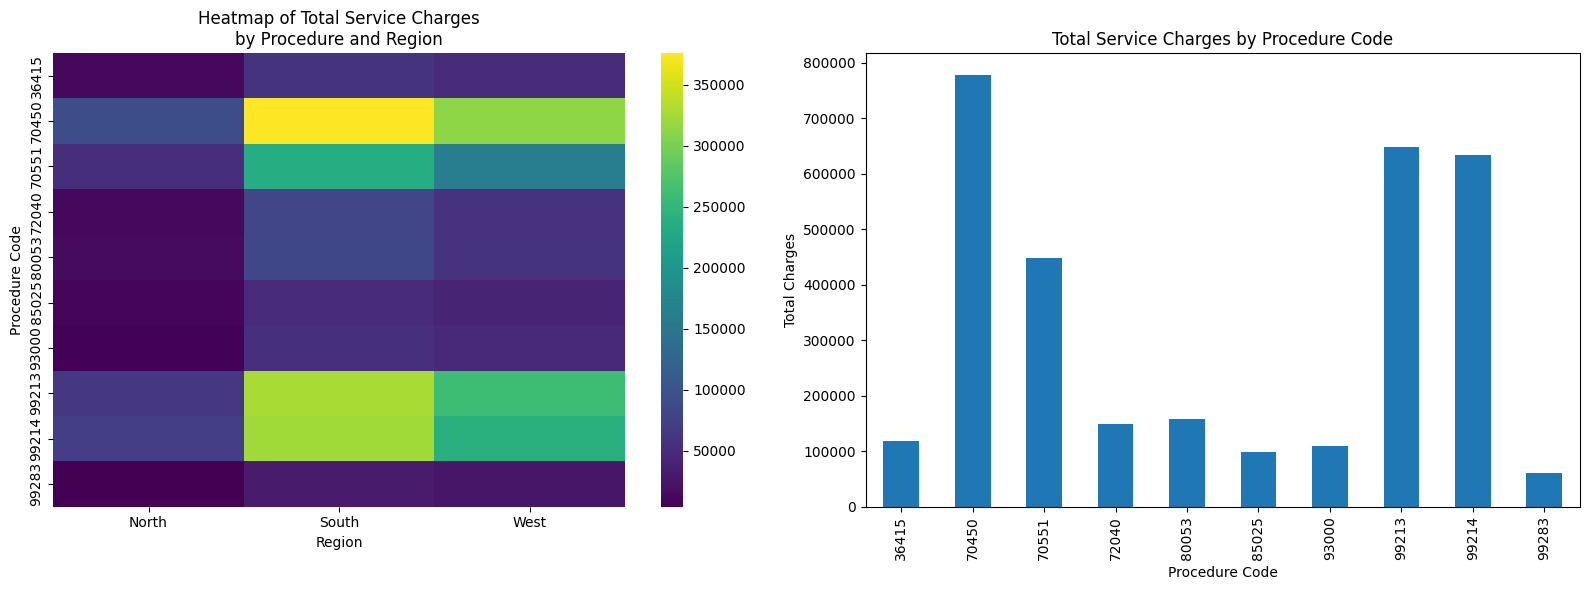

In [100]:
# TODO: Create heatmap from pivot table
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    pivot_basic,
    cmap="viridis",
    ax=axes[0]
)
axes[0].set_title("Heatmap of Total Service Charges\nby Procedure and Region")
axes[0].set_xlabel("Region")
axes[0].set_ylabel("Procedure Code")

# TODO: Create bar chart from pivot table
pivot_basic.sum(axis=1).plot(
    kind="bar",
    ax=axes[1]
)
axes[1].set_title("Total Service Charges by Procedure Code")
axes[1].set_xlabel("Procedure Code")
axes[1].set_ylabel("Total Charges")
axes[1].tick_params(axis="x", rotation=90)

fig.tight_layout()

# TODO: Customize colors and styling
# TODO: Add appropriate titles and labels

# TODO: Save the plot as 'output/q3_pivot_visualization.png'
fig.savefig("output/q3_pivot_visualization.png", dpi=300)
plt.show()


## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques